<a href="https://colab.research.google.com/github/stwind/notebooks/blob/master/unet_vanilla.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup

In [1]:
!pip install -Uq torchinfo

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import io
import os
import math
import time
import random
import requests
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import PIL
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as dset
import torchvision.transforms as tfms
import torchvision.models as models
import tensorflow as tf
import moviepy.editor as mvp
import skimage
from skimage import io
from torch.utils.data import DataLoader, Dataset, SubsetRandomSampler
from torchvision.utils import make_grid
from torchinfo import summary
from fastprogress.fastprogress import progress_bar
from matplotlib.gridspec import GridSpec
from IPython.display import Image, HTML, clear_output
from moviepy.editor import VideoClip

os.environ['FFMPEG_BINARY'] = 'ffmpeg'

sns.set('notebook', 'darkgrid', rc={
    'font.family': ['DejaVu Sans'],
    'font.sans-serif': ['Open Sans', 'Arial Unicode MS'],
    'font.size': 12,
    'figure.figsize': (8, 5),
    'grid.linewidth': 1,
    'grid.alpha': 0.5,
    'legend.fontsize': 10,
    'legend.frameon': True,
    'legend.framealpha': 0.6,
    'legend.handletextpad': 0.2,
    'lines.linewidth': 1,
    'axes.facecolor': '#fafafa',
    'axes.labelsize': 11,
    'axes.titlesize': 12,
    'axes.linewidth': 0.5,
    'xtick.labelsize': 11,
    'xtick.major.width': 0.5,
    'ytick.labelsize': 11,
    'ytick.major.width': 0.5,
    'figure.titlesize': 13,
})
plt.style.use("dark_background")

print("Infos:")
print("numpy: {}".format(np.__version__))
print("seaborn: {}".format(sns.__version__))
print("matplotlib: {}".format(mpl.__version__))
print("pytorch: {}".format(torch.__version__))
for i in range(torch.cuda.device_count()):
    print("cuda device #{}: {}".format(i, torch.cuda.get_device_name(i)))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("current device type: {}".format(device.type))

Infos:
numpy: 1.19.5
seaborn: 0.11.1
matplotlib: 3.2.2
pytorch: 1.7.0+cu101
cuda device #0: Tesla T4
current device type: cuda


## Utils

In [3]:
def imshow(img, figsize=(5,5), title=None, cmap=None):
    plt.figure(figsize=figsize)
    plt.imshow(img, cmap)
    if title is not None:
        plt.title(title)
    plt.axis('off')
    plt.show()

## Data

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/kaggle"

# !kaggle datasets download veeralakrishna/butterfly-dataset
# dset.utils.extract_archive("butterfly-dataset.zip")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [5]:
def get_train_val_loader(dataset, split=0.1, batch_size=64, num_workers=2):
    train_size = len(dataset)
    indices = np.random.permutation(range(train_size))
    
    split_idx = int(np.floor((1 - split) * train_size))
    train_sampler = SubsetRandomSampler(indices[:split_idx])
    val_sampler = SubsetRandomSampler(indices[split_idx:])
    train_loader = DataLoader(dataset, batch_size=batch_size, sampler=train_sampler, shuffle=False, num_workers=num_workers, pin_memory=True)
    val_loader = DataLoader(dataset, batch_size=batch_size, sampler=val_sampler, shuffle=False, num_workers=num_workers, pin_memory=True)
    return train_loader, val_loader


class ImageFolder(Dataset):
    def __init__(self, root, transform=None):
        super().__init__()
        self.root = root
        self.transform = transform
        self.images = []
        for p in os.listdir(os.path.join(root, "images")):
            fn = os.path.splitext(p)[0]
            self.images.append(fn)
    
    def __getitem__(self, index):
        img_path = os.path.join(self.root, "images/{}.png".format(self.images[index]))
        seg_path = os.path.join(self.root, "segmentations/{}_seg0.png".format(self.images[index]))
        img = PIL.Image.open(img_path)
        seg = PIL.Image.open(seg_path).convert("1")
        if self.transform:
            img = self.transform(img)
            seg = self.transform(seg)
        return img, seg

    def __len__(self):
        return len(self.images)
    

dataroot = "leedsbutterfly"
image_size = 64
batch_size = 64
num_workers = 16

dataset = ImageFolder(dataroot,
                      transform=tfms.Compose([tfms.Resize((image_size + 2,image_size + 2)),
                                              tfms.CenterCrop(image_size),
                                              tfms.ToTensor()]))

train_loader, val_loader = get_train_val_loader(dataset, 0.1, batch_size, num_workers)

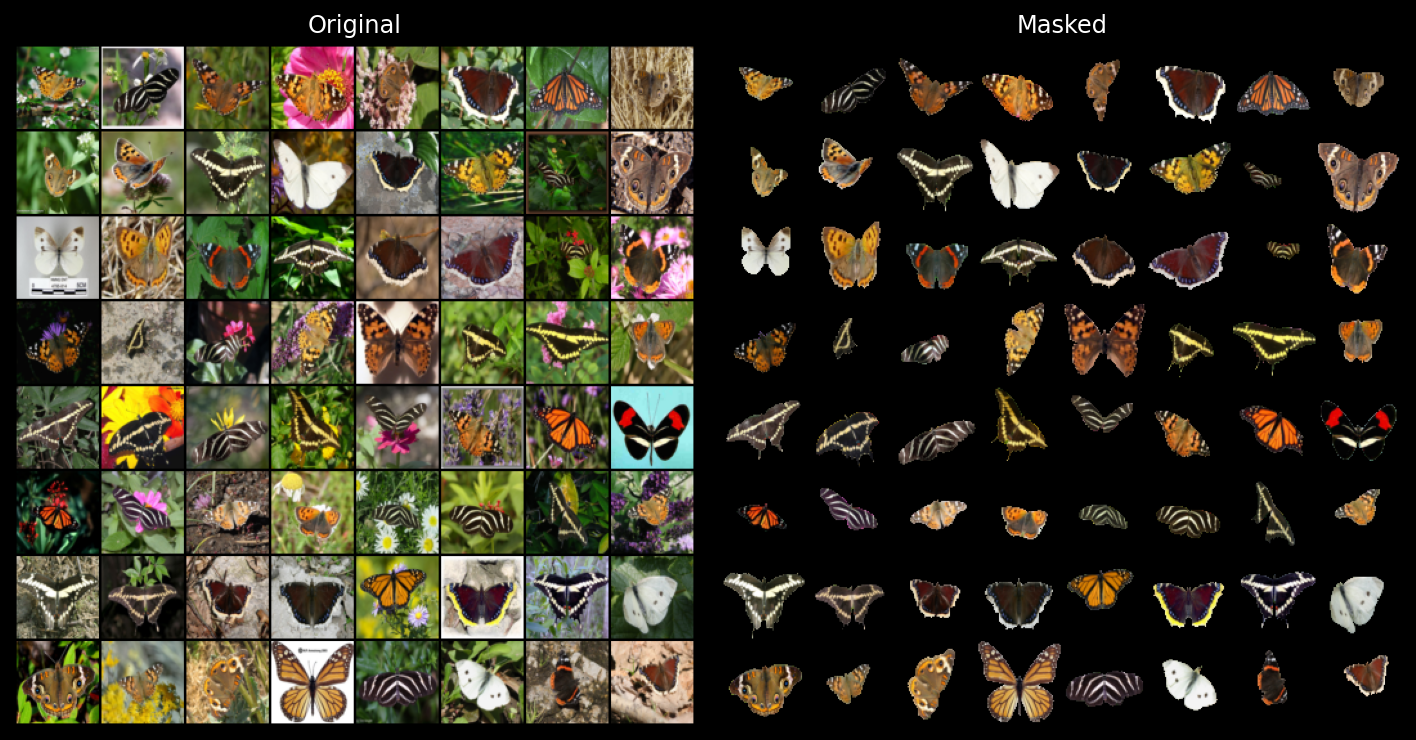

In [6]:
images, masks = next(iter(train_loader))

fig, ax = plt.subplots(1, 2, figsize=(10,6))

ax[0].imshow(make_grid(images[:64], nrow=8, padding=2).permute(1,2,0).numpy())
ax[0].set_axis_off()
ax[0].set_title("Original")

ax[1].imshow(make_grid((images*masks)[:64], nrow=8, padding=2).permute(1,2,0).numpy())
ax[1].set_axis_off()
ax[1].set_title("Masked")

plt.tight_layout()
plt.show()

## Model

In [7]:
#@title Model {vertical-output: true}

class DoubleConv(nn.Module):
    def __init__(self, cin, cout):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(cin, cout, kernel_size=3, padding=1),
            nn.BatchNorm2d(cout),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(cout, cout, kernel_size=3, padding=1),
            nn.BatchNorm2d(cout),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.model(x)
    

class UNet(nn.Module):

    def __init__(self, n_class=1):
        super().__init__()
                
        self.down1 = DoubleConv(3, 64)
        self.down2 = DoubleConv(64, 128)
        self.down3 = DoubleConv(128, 256)
        
        self.maxpool = nn.MaxPool2d(2)
        self.bottleneck = DoubleConv(256, 512)        
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)        
        
        self.up3 = DoubleConv(256 + 512, 256)
        self.up2 = DoubleConv(128 + 256, 128)
        self.up1 = DoubleConv(128 + 64, 64)
        
        self.head = nn.Conv2d(64, n_class, 1)
        
        
    def forward(self, x):
        x1 = self.down1(x)
        x = self.maxpool(x1)
        
        x2 = self.down2(x)
        x = self.maxpool(x2)
        
        x3 = self.down3(x)
        x = self.maxpool(x3)
        
        x = self.bottleneck(x)
        
        x = self.upsample(x)        
        x = torch.cat([x, x3], dim=1)
        x = self.up3(x)
        
        x = self.upsample(x)        
        x = torch.cat([x, x2], dim=1)
        x = self.up2(x)
        
        x = self.upsample(x)        
        x = torch.cat([x, x1], dim=1)
        x = self.up1(x)
        
        x = self.head(x)
        return x

model = UNet().to(device)
summary(model, (1,3,image_size,image_size),verbose=False)

Layer (type:depth-idx)                   Output Shape              Param #
├─DoubleConv: 1-1                        [1, 64, 64, 64]           --
|    └─Sequential: 2-1                   [1, 64, 64, 64]           --
|    |    └─Conv2d: 3-1                  [1, 64, 64, 64]           1,792
|    |    └─BatchNorm2d: 3-2             [1, 64, 64, 64]           128
|    |    └─ReLU: 3-3                    [1, 64, 64, 64]           --
|    |    └─Conv2d: 3-4                  [1, 64, 64, 64]           36,928
|    |    └─BatchNorm2d: 3-5             [1, 64, 64, 64]           128
|    |    └─ReLU: 3-6                    [1, 64, 64, 64]           --
├─MaxPool2d: 1-2                         [1, 64, 32, 32]           --
├─DoubleConv: 1-3                        [1, 128, 32, 32]          --
|    └─Sequential: 2-2                   [1, 128, 32, 32]          --
|    |    └─Conv2d: 3-7                  [1, 128, 32, 32]          73,856
|    |    └─BatchNorm2d: 3-8             [1, 128, 32, 32]          256
|

## Training

In [8]:
def iou_score(pred, target, eps=1e-6):
    output_ = output > 0.5
    target_ = target > 0.5
    intersection = (output_ & target_).sum(dim=(1,2,3))
    union = (output_ | target_).sum(dim=(1,2,3))
    return (intersection + eps) / (union + eps)

def dice_coef(pred, target, eps=1e-6):
    inter = (pred * target).sum(dim=(1,2,3))
    return (2. * inter + eps) / ((pred + target).sum(dim=(1,2,3)) + eps)

class BCEDiceLoss(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, pred, target):
        bce = F.binary_cross_entropy_with_logits(pred, target)
        dice = dice_coef(pred.sigmoid(), target)
        return 0.5 * bce + (1. - dice).mean()

def plot_metrics(metrics):
    fig = plt.figure(figsize=(10,4))

    for k, v in metrics.items():
        plt.plot(v, '-', alpha=0.8, label=k)

    plt.legend()
    plt.title('Metrics')
    plt.tight_layout()
    plt.show()

def plot_results(pred, target):
    fig, ax = plt.subplots(1, 2, figsize=(10,6))

    ax[0].imshow(make_grid(pred, nrow=8, padding=2).permute(1,2,0).numpy().clip(0,1))
    ax[0].set_axis_off()
    ax[0].set_title("Predicted")

    ax[1].imshow(make_grid(target, nrow=8, padding=2).permute(1,2,0).numpy().clip(0,1))
    ax[1].set_axis_off()
    ax[1].set_title("Target")

    plt.tight_layout()
    plt.show()

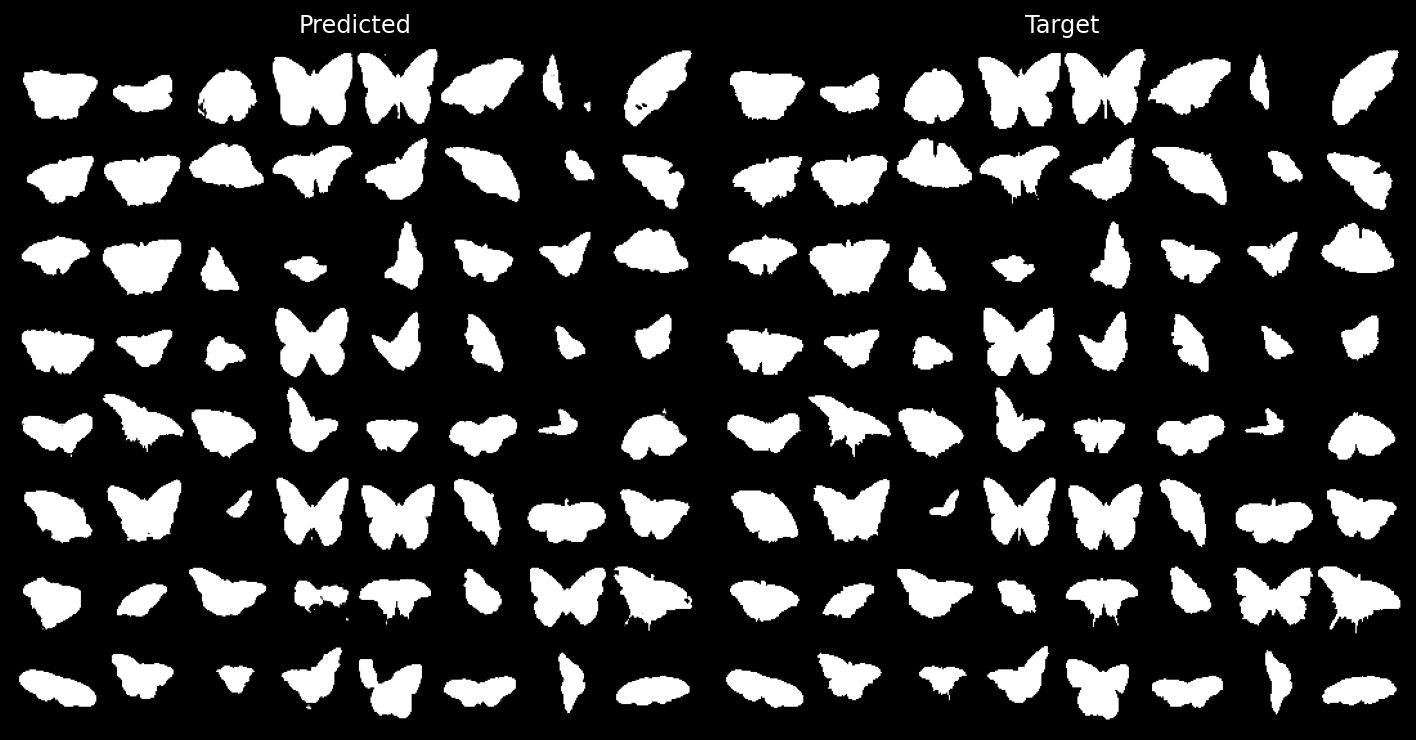

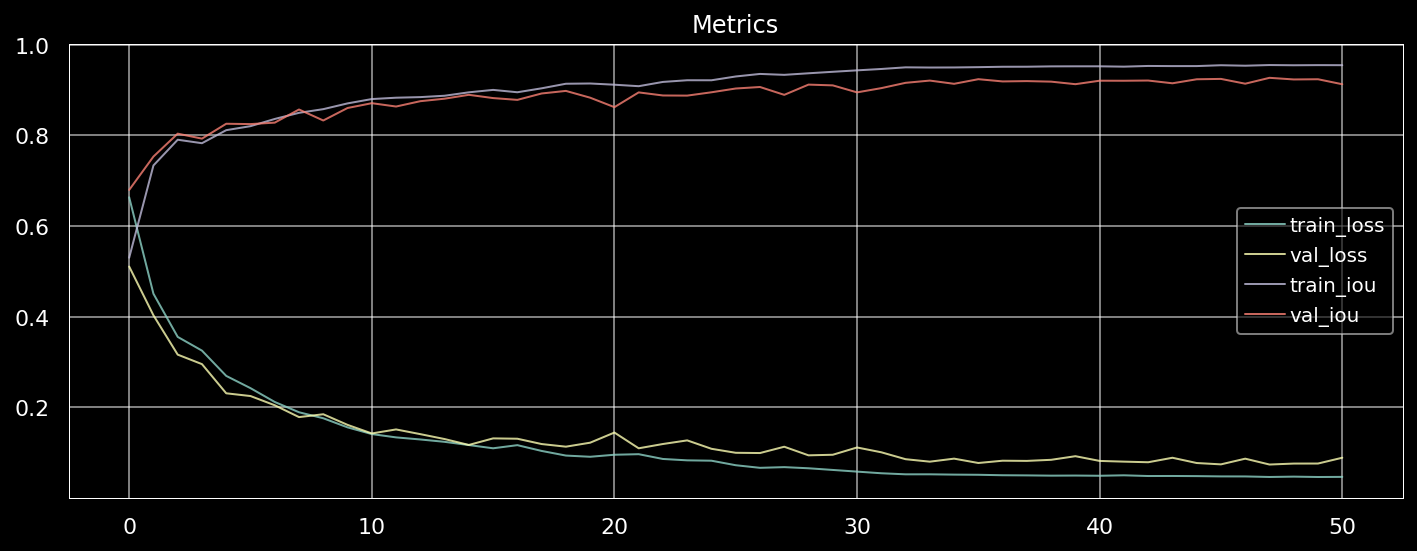

[50/51] elapsed: 865s train_loss: 0.0465 val_loss: 0.0887 train_iou: 0.9545 val_iou: 0.9125 lr: 0.0001

In [9]:
#@title Train Loop {vertical-output: true}

epochs = 51

start = time.time()

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
lr_sched = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

criterion = BCEDiceLoss()

metrics = {"train_loss": [], "val_loss": [], "train_iou": [], "val_iou": []}

for epoch in range(epochs):
    train_loss = 0.0
    train_iou = 0.0
    
    for i, (images, masks) in enumerate(train_loader):
        masks = masks.to(device)
        output = model(images.to(device))
        loss = criterion(output, masks)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.detach().cpu().item()
        train_iou += iou_score(output.sigmoid(), masks).mean()
        
    val_loss = 0.0
    val_iou = 0.0
    with torch.no_grad():
        for images, masks in val_loader:
            masks = masks.to(device)
            output = model(images.to(device))
            loss = criterion(output, masks.to(device))
            val_loss += loss.detach().cpu().item()
            val_iou += iou_score(output.sigmoid(), masks).mean()
    
    metrics["train_loss"].append(train_loss / len(train_loader))
    metrics["val_loss"].append(val_loss / len(val_loader))
    metrics["train_iou"].append(train_iou / len(train_loader))
    metrics["val_iou"].append(val_iou / len(val_loader))

    lr_sched.step()

    if epoch % 5 == 0:
        clear_output(True)

        with torch.no_grad():
            images, masks = next(iter(val_loader))
            output = model(images.to(device)).detach().cpu()
            plot_results(output, masks)

        plot_metrics(metrics)

    print("\r[{}/{}] elapsed: {}s train_loss: {:.4f} val_loss: {:.4f} train_iou: {:.4f} val_iou: {:.4f} lr: {:.4f}".format(
        epoch, epochs,
        int(time.time() - start),
        metrics["train_loss"][-1], metrics["val_loss"][-1],
        metrics["train_iou"][-1], metrics["val_iou"][-1],
        lr_sched.get_lr()[0]), 
        end="")

## Results

In [10]:
images, masks = [], []
for imgs, msks in val_loader:
    images.append(imgs)
    masks.append(msks)
images = torch.cat(images)
masks = torch.cat(masks)

with torch.no_grad():
    output = model(images.to(device)).detach().cpu()
    iou = iou_score(output, masks)

indices = iou.argsort(descending=True)

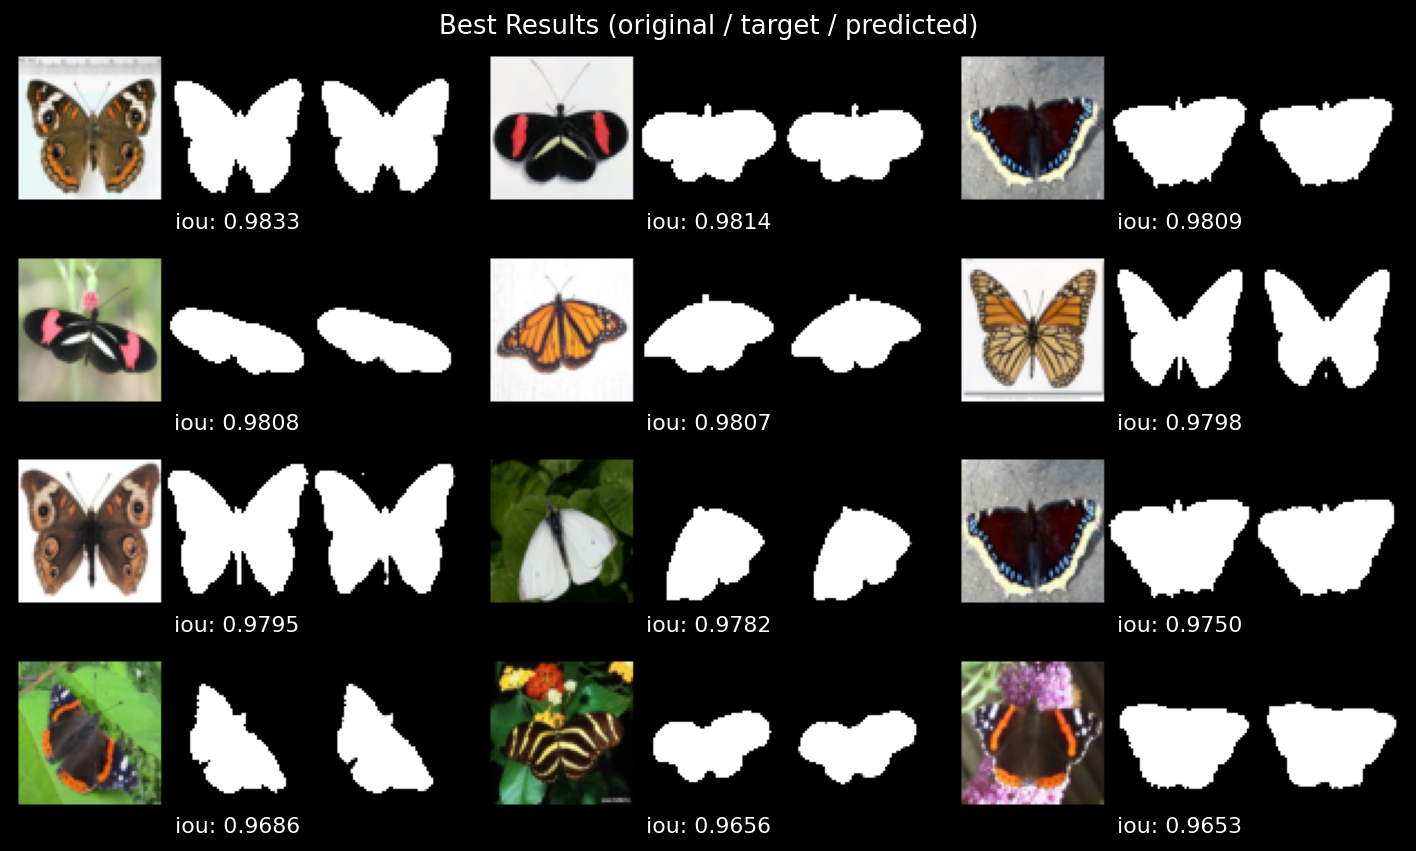

In [11]:
fig = plt.figure(figsize=(10, 6))

for i in range(12):
    idx = indices[i]
    img = torch.stack([images[idx], masks[idx].expand(3,-1,-1), output[idx].expand(3,-1,-1)])
    ax = fig.add_subplot(4, 3, i + 1)
    ax.imshow(make_grid(img).permute(1,2,0).numpy().clip(0,1))
    ax.set(xlabel="iou: {:.4f}".format(iou[idx].item()),xticks=[],yticks=[])
    sns.despine(left=True,bottom=True)

fig.suptitle("Best Results (original / target / predicted)")
plt.tight_layout(rect=[0,0,1,0.98])
plt.show()

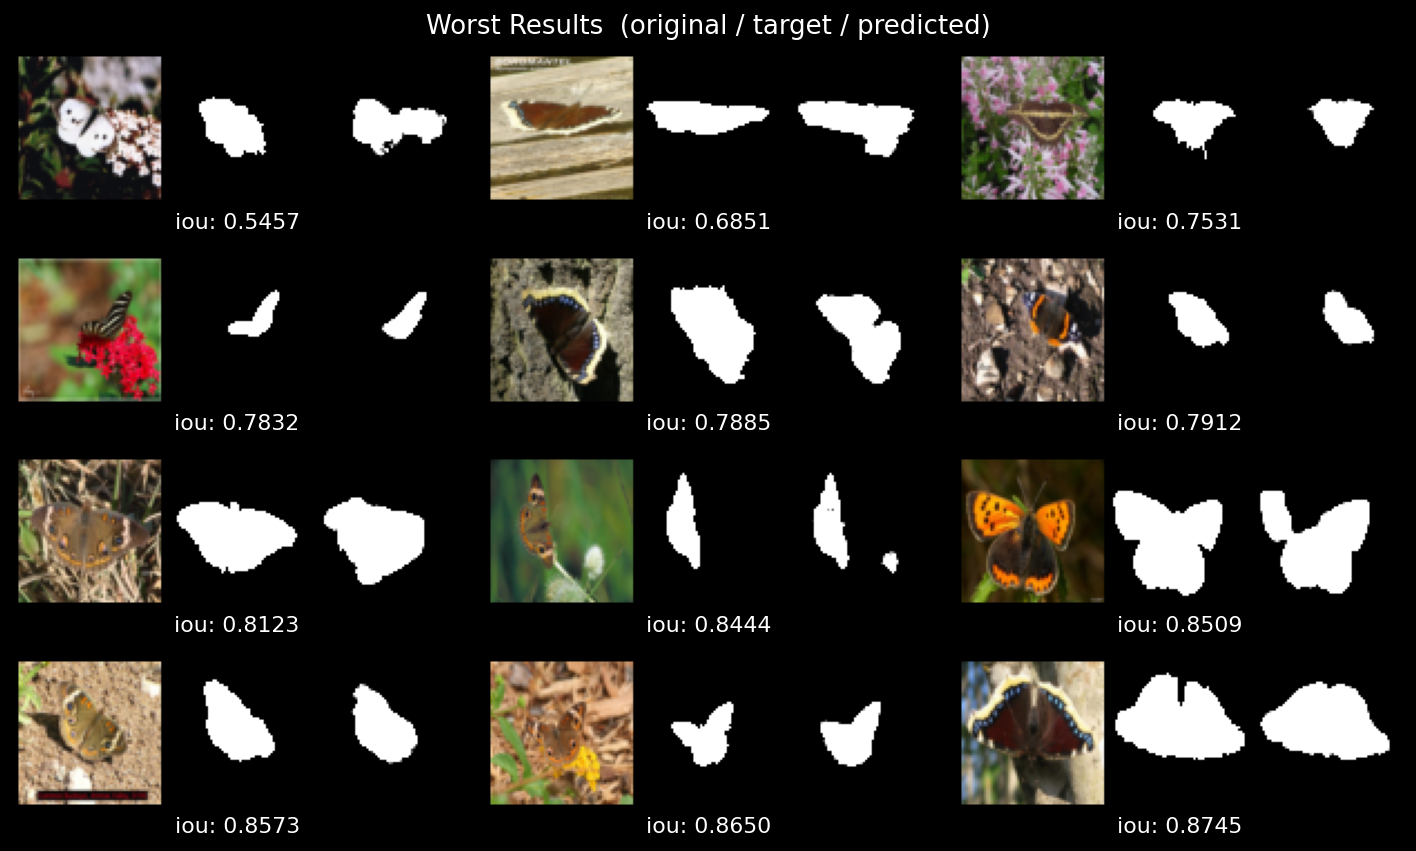

In [12]:
fig = plt.figure(figsize=(10, 6))

for i in range(12):
    idx = indices[-i-1]
    img = torch.stack([images[idx], masks[idx].expand(3,-1,-1), output[idx].expand(3,-1,-1)])
    ax = fig.add_subplot(4, 3, i + 1)
    ax.imshow(make_grid(img).permute(1,2,0).numpy().clip(0,1))
    ax.set(xlabel="iou: {:.4f}".format(iou[idx].item()),xticks=[],yticks=[])
    sns.despine(left=True,bottom=True)

fig.suptitle("Worst Results  (original / target / predicted)")
plt.tight_layout(rect=[0,0,1,0.98])
plt.show()